# Credit Card Fraud Detection using ANN (Deep Learning)

This notebook builds an **Artificial Neural Network (ANN)** to detect fraudulent credit card transactions using the Kaggle dataset **`creditcard.csv`**.

**Key points covered**
- Train/Validation/Test split (stratified)
- Feature scaling (no data leakage)
- Handling class imbalance using **class weights**
- ANN model with **Dropout + L2 Regularization**
- Evaluation using **Confusion Matrix, Classification Report**
- Metrics for imbalanced data: **ROC-AUC & PR-AUC**
- ROC Curve and Precision–Recall Curve

> Dataset: Kaggle — *Credit Card Fraud Detection (mlg-ulb/creditcardfraud)*

## 1. Imports & Load Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import joblib

# Load dataset (keep creditcard.csv in the same folder as this notebook)
df = pd.read_csv("creditcard.csv")

print("Dataset shape:", df.shape)
print("\nClass distribution (0=Normal, 1=Fraud):\n", df["Class"].value_counts())
df.head()

Dataset shape: (284807, 31)

Class distribution (0=Normal, 1=Fraud):
 Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Basic Data Checks

In [2]:
print("Missing values total:", df.isnull().sum().sum())
print("Fraud percentage:", df["Class"].mean() * 100, "%")

Missing values total: 0
Fraud percentage: 0.1727485630620034 %


## 3. Train/Validation/Test Split and Scaling

In [3]:
X = df.drop("Class", axis=1)
y = df["Class"]

# Train/Val/Test split (70/15/15) - stratified
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Scaling (NO leakage: fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

Train: (199364, 30) Val: (42721, 30) Test: (42722, 30)


## 4. Handle Class Imbalance with Class Weights

In [4]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

# Weight fraud much higher (common technique for imbalanced classification)
weight_for_0 = 1.0
weight_for_1 = neg / pos

class_weight = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weight)

Class weights: {0: 1.0, 1: 578.546511627907}


## 5. Build the ANN Model

In [5]:
tf.random.set_seed(42)

model = Sequential([
    Dense(64, activation="relu", kernel_regularizer=l2(0.001),
          input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),

    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(16, activation="relu"),
    Dropout(0.2),

    Dense(1, activation="sigmoid")  # Binary output
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

model.summary()

C:\Users\saikr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [6]:
early_stop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=60,
    batch_size=2048,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - auc: 0.7869 - loss: 1.1805 - precision: 0.0065 - recall: 0.7093 - val_auc: 0.9382 - val_loss: 0.4181 - val_precision: 0.0608 - val_recall: 0.8649
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - auc: 0.9502 - loss: 0.6709 - precision: 0.0255 - recall: 0.8895 - val_auc: 0.9527 - val_loss: 0.2269 - val_precision: 0.0812 - val_recall: 0.8919
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - auc: 0.9693 - loss: 0.5076 - precision: 0.0375 - recall: 0.9070 - val_auc: 0.9621 - val_loss: 0.1907 - val_precision: 0.0726 - val_recall: 0.8919
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.9696 - loss: 0.4885 - precision: 0.0338 - recall: 0.9157 - val_auc: 0.9699 - val_loss: 0.1819 - val_precision: 0.0686 - val_recall: 0.8784
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - auc: 0.9758 - loss: 0.4410 - precision: 0.0437 - recall: 0.9215 - val_auc: 0.9746 - val_loss: 0.1753 - val_precision: 0.0614 - val_recall: 0.8784
Epoch

## 7. Plot Training Curves

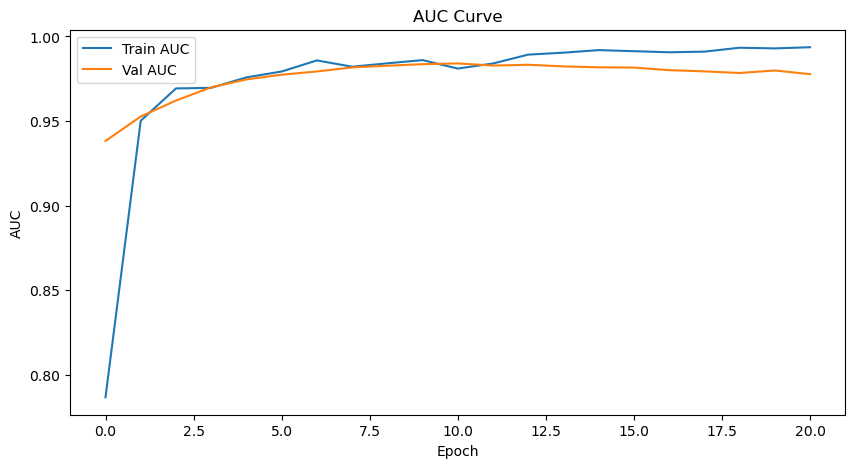

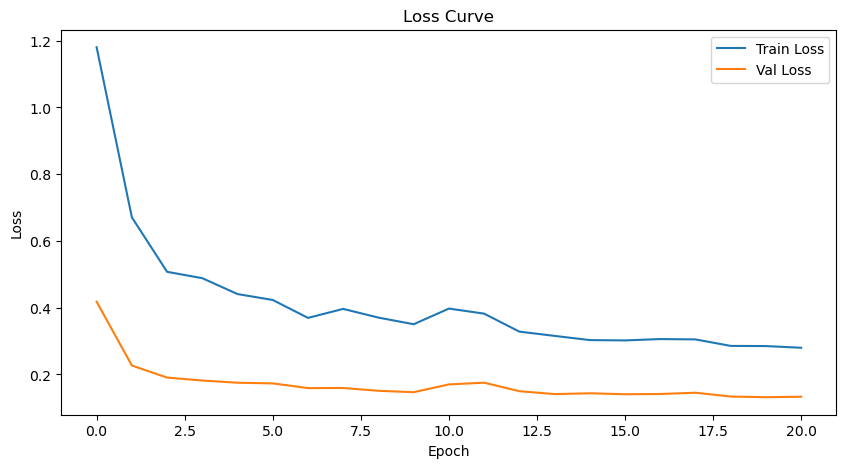

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["auc"], label="Train AUC")
plt.plot(history.history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC Curve")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## 8. Predictions (`y_pred`)

In [8]:
# Predict probabilities for test set
y_test_prob = model.predict(X_test_scaled).ravel()

# Default threshold 0.5
y_pred = (y_test_prob >= 0.5).astype(int)

print("y_pred sample:", y_pred[:20])

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
y_pred sample: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 9. (Recommended) Threshold Tuning on Validation Set

In [9]:
# Tune the threshold to improve fraud detection performance (F1-like balancing)
y_val_prob = model.predict(X_val_scaled).ravel()
thresholds = np.arange(0.1, 0.9, 0.05)

best_thr = 0.5
best_f1 = -1

for thr in thresholds:
    y_val_pred = (y_val_prob >= thr).astype(int)

    tp = ((y_val == 1) & (y_val_pred == 1)).sum()
    fp = ((y_val == 0) & (y_val_pred == 1)).sum()
    fn = ((y_val == 1) & (y_val_pred == 0)).sum()

    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best Threshold:", best_thr)
print("Best Val F1:", best_f1)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Best Threshold: 0.8500000000000002
Best Val F1: 0.3333333330088984


## 10. Final Evaluation on Test Set

In [10]:
# Use tuned threshold for final prediction (recommended)
y_test_pred = (y_test_prob >= best_thr).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_test_prob)
pr_auc  = average_precision_score(y_test, y_test_prob)

print("ROC-AUC:", roc_auc)
print("PR-AUC (Average Precision):", pr_auc)


Confusion Matrix:
 [[42425   223]
 [   11    63]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9948    0.9972     42648
           1     0.2203    0.8514    0.3500        74

    accuracy                         0.9945     42722
   macro avg     0.6100    0.9231    0.6736     42722
weighted avg     0.9984    0.9945    0.9961     42722

ROC-AUC: 0.9737841386687757
PR-AUC (Average Precision): 0.7402022116152653


## 11. ROC Curve and Precision–Recall Curve

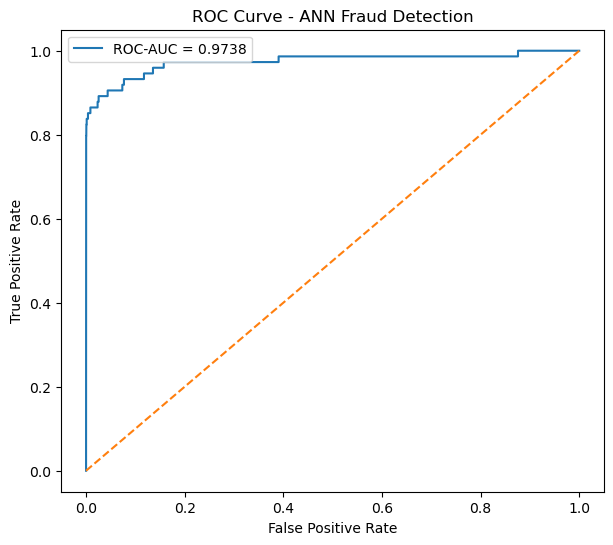

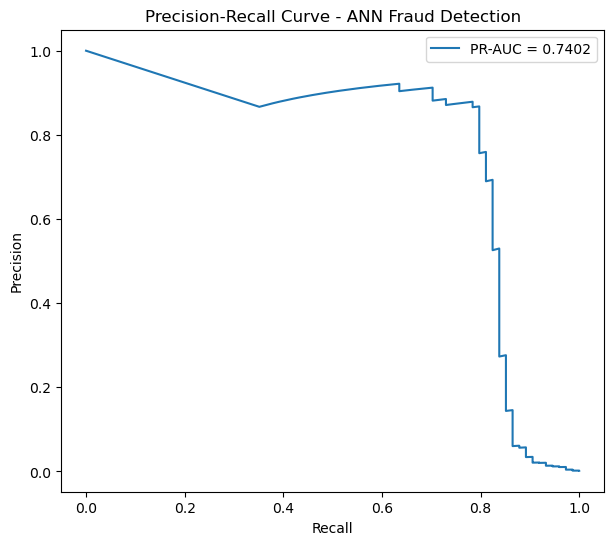

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ANN Fraud Detection")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - ANN Fraud Detection")
plt.legend()
plt.show()

## 12. Save Model & Scaler

In [12]:
model.save("fraud_detection_ann_model.keras")
joblib.dump(scaler, "scaler.pkl")

print("Saved: fraud_detection_ann_model.keras and scaler.pkl")

Saved: fraud_detection_ann_model.keras and scaler.pkl
